## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## Generate Sample Data

In [2]:
np.random.seed(42)

def generate_sample_data():
    df = pd.DataFrame(
        data={'date': pd.date_range(start='2018-01-01', end='2020-12-31', freq='W')}
    )

    n = df.shape[0]

    df['t'] = np.linspace(start=1, stop=n, num=n)
    df['x1'] = np.random.uniform(low=-1.0, high=1.0, size=n)
    df['x1'] = df['x1'].apply(lambda x: x if abs(x) > 0.7 else 0.0)
    df['x2'] = 10*np.log(df['t'])
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofyear_sc'] = np.sin(2*np.pi*df['dayofyear']/365.5)
    df['dayofyear_cc'] = np.cos(2*np.pi*df['dayofyear']/365.5)
    df['y'] = 10.0 + 20*df['x1'] + df['x2'] + 15*df['dayofyear_sc'] + 5*df['dayofyear_cc']
    df['y'] = df['y'] + np.random.normal(loc=0.0, scale=5.0, size=n)
    return df

data_df = generate_sample_data()

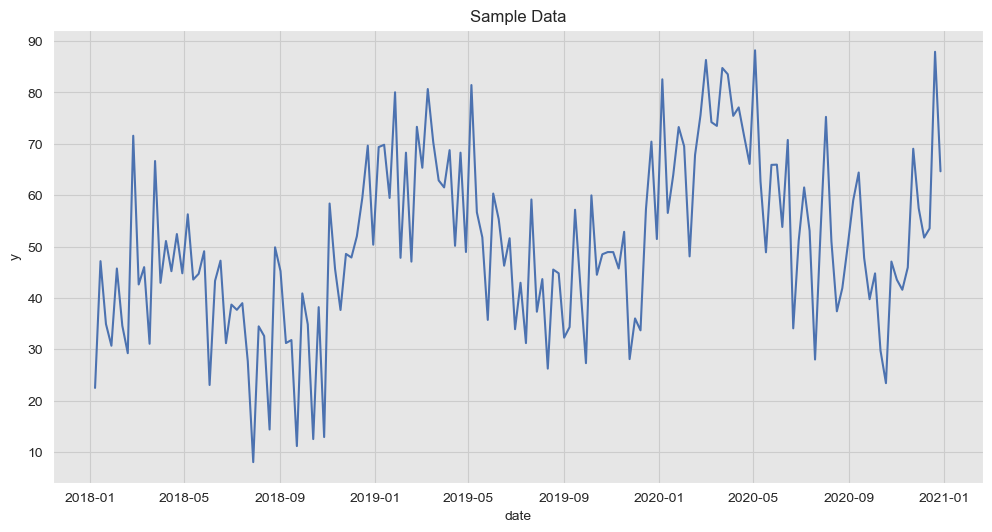

In [3]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', data=data_df, color=sns_c[0], ax=ax)
ax.set(title='Sample Data');

## Train-Test Split

In [4]:
threshold_date = '2020-07-01'

data_train_df = data_df.query(f'date < "{threshold_date}"')
data_test_df = data_df.query(f'date >= "{threshold_date}"')

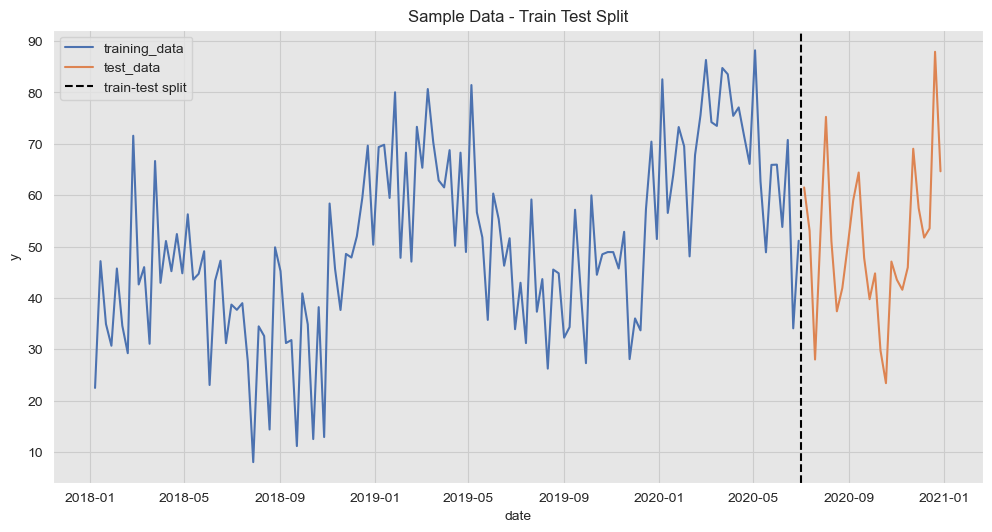

In [5]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', data=data_train_df, color=sns_c[0], label='training_data', ax=ax)
sns.lineplot(x='date', y='y', data=data_test_df, color=sns_c[1], label='test_data', ax=ax)
ax.axvline(threshold_date, color='black', linestyle='--', label='train-test split')
ax.legend(loc='upper left')
ax.set(title='Sample Data - Train Test Split');

## Plot Features

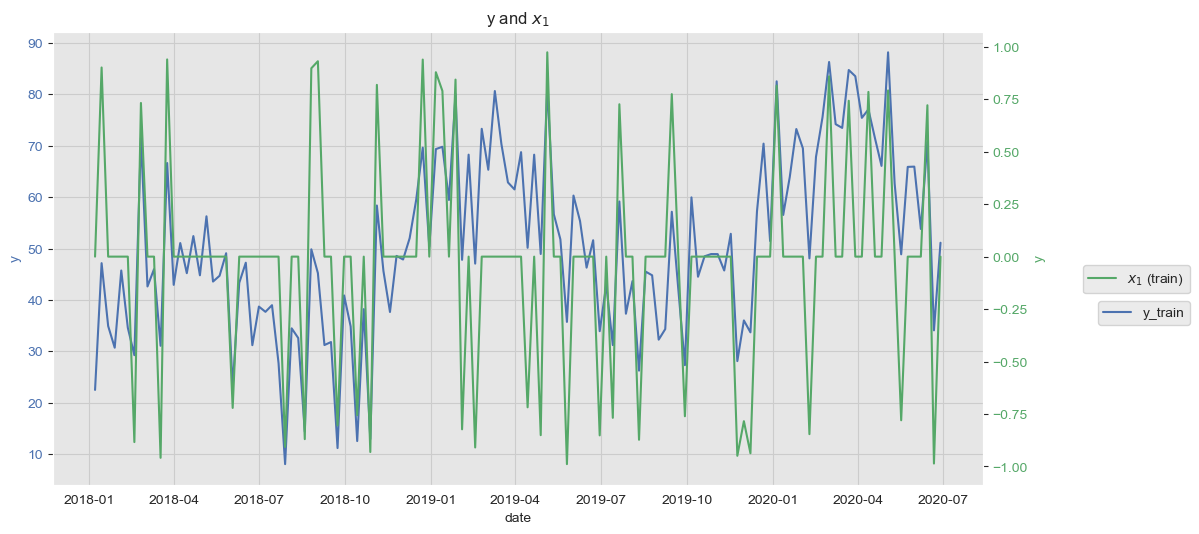

In [6]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
sns.lineplot(x='date', y='y', data=data_train_df, color=sns_c[0], label='y_train', ax=ax1)
sns.lineplot(x='date', y='x1', data=data_train_df, color=sns_c[2], label=f'$x_1$ (train)', ax=ax2)
ax1.legend(bbox_to_anchor=(1.23, 0.42))
ax2.legend(bbox_to_anchor=(1.23, 0.5))
ax1.tick_params(axis='y', labelcolor=sns_c[0])
ax1.set_ylabel('y', fontdict={'color': sns_c[0]})
ax1.set(title=f'y and $x_1$')
ax2.grid(None)
ax2.tick_params(axis='y', labelcolor=sns_c[2])
ax2.set_ylabel('y', fontdict={'color': sns_c[2]});

## Linear Model

In [7]:
model_formula = 'y ~ x1 + x2 + dayofyear_sc + dayofyear_cc'
model = smf.ols(model_formula, data=data_train_df)
result = model.fit()

print(result.summary())

OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     367.5
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           4.47e-68
Time:                        22:43:17   Log-Likelihood:                -389.73
No. Observations:                 130   AIC:                             789.5
Df Residuals:                     125   BIC:                             803.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       11.2627      1.899      5.931      0.000       7.505      15

## Predictions

In [8]:
train_pred_df = result.get_prediction(data_train_df).summary_frame()
train_pred_df.columns = 'pred_' + train_pred_df.columns
train_pred_df = pd.concat([data_train_df, train_pred_df], axis=1)

train_pred_df = train_pred_df.assign(
        error = lambda x: x['pred_mean'] - x['y'],
        abs_error = lambda x: x['error'].abs(),
        p_error = lambda x: x['error'].div(x['y'])
    )

test_pred_df = result.get_prediction(data_test_df).summary_frame()
test_pred_df.columns = 'pred_' + test_pred_df.columns
test_pred_df = pd.concat([data_test_df.reset_index(drop=True), test_pred_df], axis=1)

test_pred_df = test_pred_df.assign(
        error = lambda x: x['pred_mean'] - x['y'],
        abs_error = lambda x: x['error'].abs(),
        p_error = lambda x: x['error'].div(x['y'])
    )

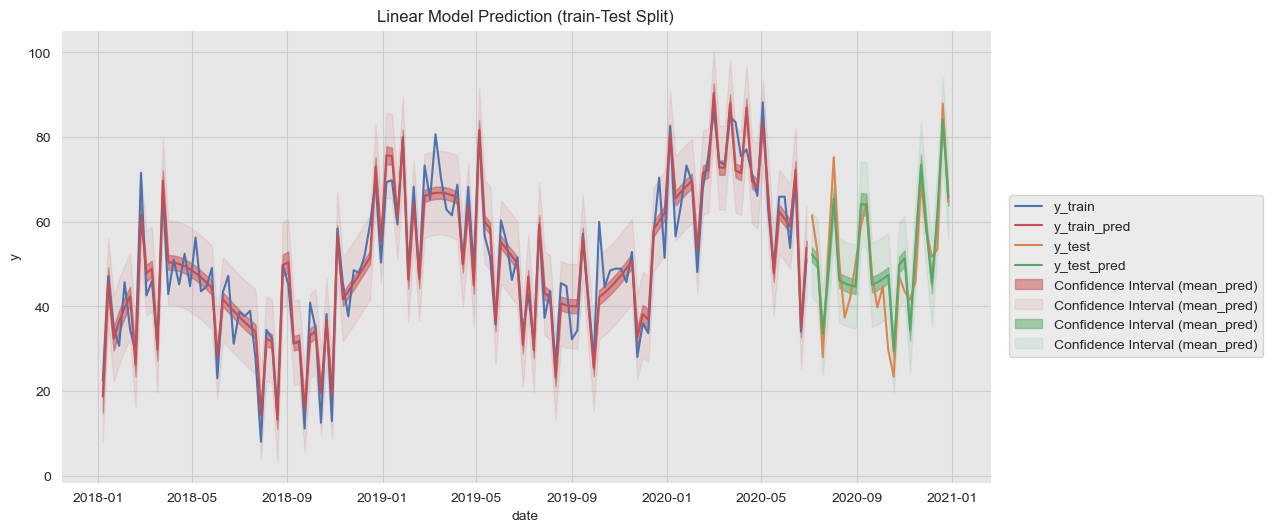

In [10]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', data=train_pred_df, color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x='date', y='pred_mean', data=train_pred_df, color=sns_c[3], label='y_train_pred', ax=ax)
ax.fill_between(
    x=train_pred_df['date'],
    y1=train_pred_df['pred_mean_ci_lower'],
    y2=train_pred_df['pred_mean_ci_upper'],
    color=sns_c[3], 
    alpha=0.5,
    label='Confidence Interval (mean_pred)'
)
ax.fill_between(
    x=train_pred_df['date'],
    y1=train_pred_df['pred_obs_ci_lower'],
    y2=train_pred_df['pred_obs_ci_upper'],
    color=sns_c[3], 
    alpha=0.10,
    label='Confidence Interval (mean_pred)'
)
sns.lineplot(x='date', y='y', data=test_pred_df, color=sns_c[1], label='y_test', ax=ax)
sns.lineplot(x='date', y='pred_mean', data=test_pred_df, color=sns_c[2], label='y_test_pred', ax=ax)
ax.fill_between(
    x=test_pred_df['date'],
    y1=test_pred_df['pred_mean_ci_lower'],
    y2=test_pred_df['pred_mean_ci_upper'],
    color=sns_c[2], 
    alpha=0.5,
    label='Confidence Interval (mean_pred)'
)
ax.fill_between(
    x=test_pred_df['date'],
    y1=test_pred_df['pred_obs_ci_lower'],
    y2=test_pred_df['pred_obs_ci_upper'],
    color=sns_c[2], 
    alpha=0.10,
    label='Confidence Interval (mean_pred)'
)
ax.legend(bbox_to_anchor=(1.3, 0.65))
ax.set(title='Linear Model Prediction (train-Test Split)', ylabel='y');